In [187]:
import pandas as pd
import matplotlib.pyplot as plt

from ast import literal_eval

In [188]:
cols_of_interest = ['wonum', 'component', 'failure_mechanism', 'failure_influence']

In [ ]:
uot = pd.read_csv('enriched_work_orders_uot.csv') # (0.99, 0.75)
cossim = pd.read_csv('enriched_work_orders_cossim.csv')
gt = pd.read_csv('enriched_work_orders_with_manual_validation.csv')

In [190]:
uot = uot[cols_of_interest+['match_score']]
cossim = cossim[cols_of_interest+['match_score']]
gt = gt[['wonum'] + [x+'_expert_selected' for x in cols_of_interest[1:]]]

uot

,wonum,component,failure_mechanism,failure_influence,match_score
0,96827,"Filter, Control Air Supply","['Broken', 'Clogged']","['Personnel error', 'Dirt, air supply contamin...",0.319025
1,96824,"Filter, Control Air Supply","['Broken', 'Clogged']","['Personnel error', 'Dirt, air supply contamin...",0.319549
2,112409,"Filter, Control Air Supply","['Broken', 'Clogged']","['Personnel error', 'Dirt, air supply contamin...",0.333231
3,112410,"Filter, Control Air Supply","['Broken', 'Clogged']","['Personnel error', 'Dirt, air supply contamin...",0.333231
4,70068,"Filter, Control Air Supply","['Broken', 'Clogged']","['Personnel error', 'Dirt, air supply contamin...",0.333319
...,...,...,...,...,...
128,7145,Chiller Instrumentation and Control Devices: C...,"['Drift', 'General tubing failure', 'Elastomer...","['Aging (refrigerant attack)', 'Heat', 'Aging,...",0.083327
129,72681,"Compressor, Lubrication Failure","['Low oil level', 'High or low oil pressure', ...","['Aging of pump, duty cycle', 'Clogged / crush...",0.142857
130,78226,Compressor System Failure,['Inadequate system differential pressure'],['Low load'],0.655560
131,92649,"Compressor, Lubrication Failure","['Low oil level', 'High or low oil pressure', ...","['Aging of pump, duty cycle', 'Clogged / crush...",0.142856


In [191]:
gt = gt.fillna('[]')

for col in ['failure_mechanism']:
    uot[col] = uot[col].apply(lambda x: sorted(literal_eval(x)))
    cossim[col] = cossim[col].apply(lambda x: sorted(literal_eval(x)))
    gt[col+'_expert_selected'] = gt[col+'_expert_selected'].apply(lambda x: sorted(literal_eval(x)))

In [192]:
def eval_exact_matches(test, gt, cols=['component'], threshold=0.0):
    scores = {col: 0.0 for col in cols}
    for col in cols:
        scores[col] = ((test[col] == gt[col+'_expert_selected']) & (test['match_score'] >= threshold)).mean()
    return scores

import numpy as np
def tune_threshold(test, gt, step=0.1):
    results = {}
    for t in np.arange(0,1.0,step):
        results[t] = eval_exact_matches(test, gt, threshold=t)['component']
    return results

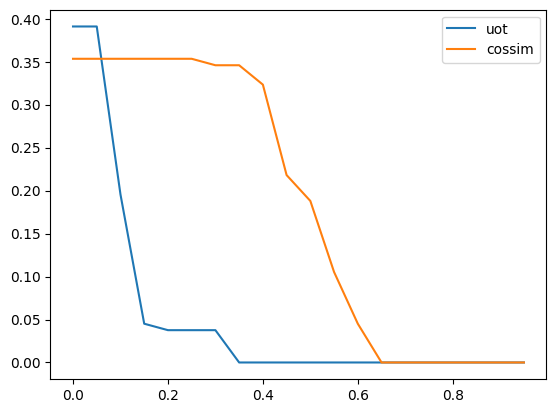

In [193]:
uot_results = tune_threshold(uot, gt, step=0.05)
cossim_results = tune_threshold(cossim, gt, step=0.05)

plt.plot(uot_results.keys(), uot_results.values(), label='uot')
plt.plot(cossim_results.keys(), cossim_results.values(), label='cossim')
plt.legend()

Text(0, 0.5, 'Accuracy')

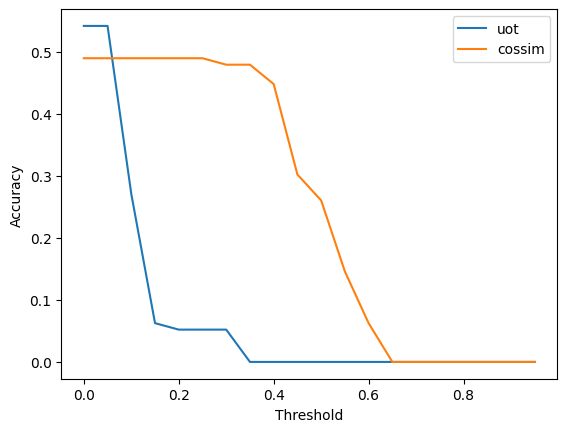

In [195]:
selection_map = gt['failure_mechanism_expert_selected'].apply(len) > 0.0

uot_filt_results = tune_threshold(uot[selection_map], gt[selection_map], step=0.05)
cossim_filt_results = tune_threshold(cossim[selection_map], gt[selection_map], step=0.05)

plt.plot(uot_filt_results.keys(), uot_filt_results.values(), label='uot')
plt.plot(cossim_filt_results.keys(), cossim_filt_results.values(), label='cossim')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Accuracy')